In [13]:
import random

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import openpyxl
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow


In [14]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [15]:
# Path for Tess dataset
tess = "datasets/TESS"
# Path for Savee dataset
savee = "datasets/Savee"

In [16]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess + "/" + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + "/" + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df.shape)
Tess_df.head()


(2800, 2)


,Emotions,Path
0,angry,datasets/TESS/OAF_angry/OAF_back_angry.wav
1,angry,datasets/TESS/OAF_angry/OAF_bar_angry.wav
2,angry,datasets/TESS/OAF_angry/OAF_base_angry.wav
3,angry,datasets/TESS/OAF_angry/OAF_bath_angry.wav
4,angry,datasets/TESS/OAF_angry/OAF_bean_angry.wav


In [17]:
savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee + "/" + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,datasets/Savee/DC_a01.wav
1,angry,datasets/Savee/DC_a02.wav
2,angry,datasets/Savee/DC_a03.wav
3,angry,datasets/Savee/DC_a04.wav
4,angry,datasets/Savee/DC_a05.wav


In [18]:
emotionCount = {}
for i in Savee_df.index:
    emotions = Savee_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions]+=1
    else:
        emotionCount[emotions]=1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 60, 'disgust': 60, 'fear': 60, 'happy': 60, 'neutral': 120, 'sad': 60, 'surprise': 60}


In [19]:
smallCount = min(emotionCount.values())
print(smallCount)
print(Savee_df.shape)

60
(480, 2)


In [20]:
counts = Savee_df['Emotions'].value_counts()

# find the minimum count
min_count = counts.min()

# create a list to store the balanced dataframes
balanced_dfs = []

# iterate over the emotions
for emotion in counts.index:
    # subset the data for the current emotion to have the minimum count
    balanced_df = Savee_df[Savee_df['Emotions'] == emotion].head(min_count)
    balanced_dfs.append(balanced_df)

# concatenate all the balanced dataframes into one final dataframe
final_df = pd.concat(balanced_dfs)
Savee_df = final_df
Savee_df


,Emotions,Path
60,neutral,datasets/Savee/DC_n01.wav
61,neutral,datasets/Savee/DC_n02.wav
62,neutral,datasets/Savee/DC_n03.wav
63,neutral,datasets/Savee/DC_n04.wav
64,neutral,datasets/Savee/DC_n05.wav
...,...,...
475,surprise,datasets/Savee/KL_su11.wav
476,surprise,datasets/Savee/KL_su12.wav
477,surprise,datasets/Savee/KL_su13.wav
478,surprise,datasets/Savee/KL_su14.wav


In [21]:
emotionCount = {}
for i in Savee_df.index:
    emotions = Savee_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions]+=1
    else:
        emotionCount[emotions]=1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 60, 'disgust': 60, 'fear': 60, 'happy': 60, 'neutral': 60, 'sad': 60, 'surprise': 60}


In [22]:
data_path = pd.concat([Tess_df,Savee_df], axis=0)
data_path.to_csv("data_path_T_S.csv", index=False)
data_path.head()
data_path.shape

(3220, 2)

In [23]:
emotionList = pd.read_csv("data_path_T_S.csv")
emotions = emotionList["Emotions"]
emotionCount = {}
for item in emotions:
    if item in emotionCount:
        emotionCount[item] += 1
    else:
        emotionCount[item] = 1
emotionCount=dict(sorted(emotionCount.items(), key=lambda x:x[0]))
print(emotionCount)

{'angry': 460, 'disgust': 460, 'fear': 460, 'happy': 460, 'neutral': 460, 'sad': 460, 'surprise': 460}


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

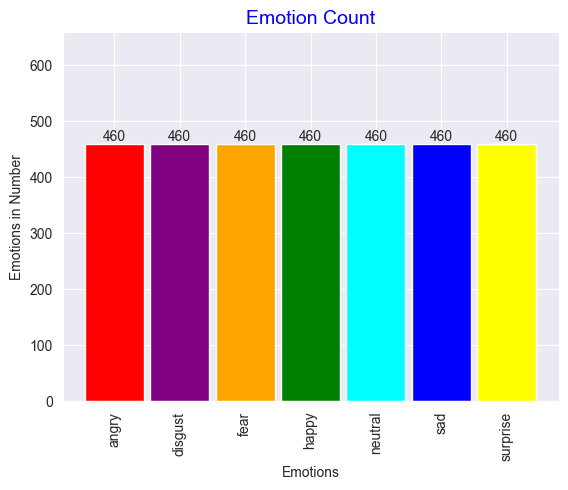

In [24]:
plt.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt.xlabel("Emotions")
plt.xticks(rotation=90)
plt.ylabel("Emotions in Number")
plt.title("Emotion Count", size=14, color="Blue")
plt.ylim([0, max(emotionCount.values()) + 200])
lst = []
for item in emotionCount:
    plt.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")
sorted(emotionCount)

# emotionCount.values()

# for index, value in enumerate(emotionCount)
# for index,value in enumerate(emotionCount.values()):
#     plt.text(value,index,value)
# plt.show()


In [25]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [26]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def volumeAdd(data):
    songData = AudioSegment.from_wav(data)
    print("sing", songData)
    songDataSamples = np.array(songData.get_array_of_samples())
    songHighVolumed = songDataSamples - 10000.0
    print(songHighVolumed)
    return songHighVolumed


datasets/TESS/OAF_angry/OAF_bar_angry.wav


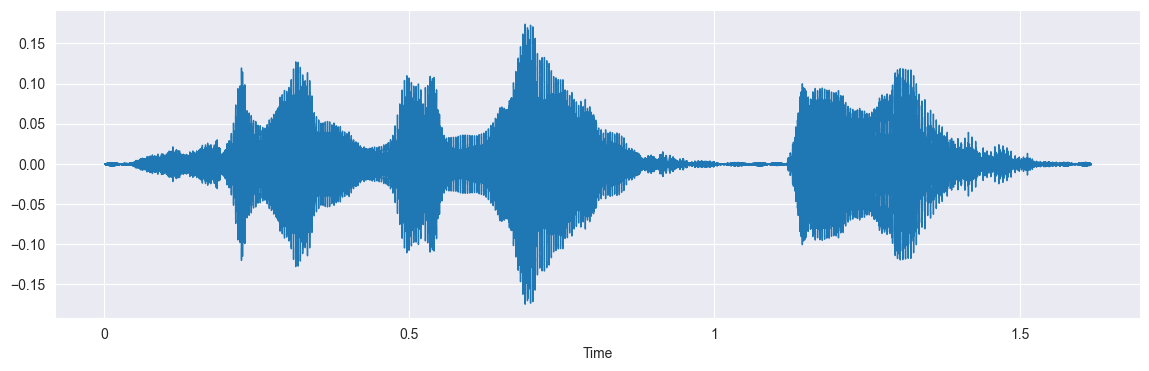

In [27]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)


In [28]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    # data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=1)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        feature = get_features(path)
    except:
        print(path)
        print(emotion)
    for ele in feature:
        try:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        except:
            print(ele)

datasets/TESS/OAF_angry/OAF_jar_angry.wav
angry
datasets/TESS/OAF_angry/OAF_kite_angry.wav
angry
datasets/TESS/OAF_angry/OAF_late_angry.wav
angry
datasets/TESS/OAF_angry/OAF_lean_angry.wav
angry
datasets/TESS/OAF_angry/OAF_lease_angry.wav
angry
datasets/TESS/OAF_angry/OAF_life_angry.wav
angry
datasets/TESS/OAF_angry/OAF_live_angry.wav
angry
datasets/TESS/OAF_angry/OAF_long_angry.wav
angry
datasets/TESS/OAF_angry/OAF_lose_angry.wav
angry
datasets/TESS/OAF_angry/OAF_love_angry.wav
angry
datasets/TESS/OAF_angry/OAF_make_angry.wav
angry
datasets/TESS/OAF_angry/OAF_merge_angry.wav
angry
datasets/TESS/OAF_angry/OAF_met_angry.wav
angry
datasets/TESS/OAF_angry/OAF_mill_angry.wav
angry
datasets/TESS/OAF_angry/OAF_mode_angry.wav
angry
datasets/TESS/OAF_angry/OAF_moon_angry.wav
angry
datasets/TESS/OAF_angry/OAF_mouse_angry.wav
angry
datasets/TESS/OAF_angry/OAF_pole_angry.wav
angry
datasets/TESS/OAF_angry/OAF_puff_angry.wav
angry
datasets/TESS/OAF_angry/OAF_raid_angry.wav
angry
datasets/TESS/OAF_a

In [ ]:
len(X), len(Y), data_path.Path.shape
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_excel('features_T_S.xlsx', index=False)
Features.head()

In [ ]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

In [ ]:
features_df = pd.read_excel("features_T_S.xlsx")
featuresofit = np.asarray(features_df.iloc[:,:-1].values)
X = featuresofit
labelofit = np.asarray(features_df['labels'])
Y = labelofit

In [ ]:
emotionsfromFeatures = features_df['labels']
emotionCountfromFeatures = {}
for item in emotionsfromFeatures:
    if item in emotionCountfromFeatures:
        emotionCountfromFeatures[item] += 1
    else:
        emotionCountfromFeatures[item] = 1
print(emotionCountfromFeatures)

In [ ]:
fig, (plt1,plt2) = plt.subplots(1,2,sharey=True, figsize=(12,3))
plt1.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt1.set_xlabel("Emotions")
plt1.set_ylabel("Emotions in Number")
plt1.set_title("Emotion Count", size=14, color="Blue")
plt1.set_ylim([0, max(emotionCount.values()) + 200])
# lst = []
for item in emotionCount:
    plt1.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")

plt2.bar(emotionCountfromFeatures.keys(), emotionCountfromFeatures.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt2.set_xlabel("Emotions from Features")
plt2.set_ylabel("Emotions from features in Number")
plt2.set_title("Emotion Count from Features", size=14, color="Blue")
plt2.set_ylim([0, max(emotionCountfromFeatures.values()) + 200])
# lst = []
for item in emotionCountfromFeatures:
    plt2.text(item, emotionCountfromFeatures[item],
             emotionCountfromFeatures[item], ha="center", va="bottom")
# plt2.subplots(nrows=1,ncols=2)

In [ ]:
# print(Y)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# pd.DataFrame(Y)

In [ ]:
scaler = StandardScaler()
# scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# kernelchoice = ["rbf"]
kernelchoice = ["linear"]
C_choice = [100, 150, 200, 250, 300]
# C_choice = [0.5, 0.6, 0.8, 0.9, 1]
import random

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

for i in C_choice:
    a=random.choice(kernelchoice)
    b=random.choice(C_choice)
    classifier = svm.SVC(kernel='linear', gamma="auto", C=b)
    classifier = OneVsRestClassifier(classifier)
    classifier.fit(x_train, y_train)
    y_predict = classifier.predict(x_test)
    accuracyPercent = accuracy_score(y_test, y_predict) * 100
    print("Kernel:  "+ str(a) + "  ||  "+" C: " + str(b) +"  ||  Accuracy"+ "  :  " + str(accuracyPercent))

In [ ]:
print(classification_report(y_test, y_predict))